# Benchmarking scib simulation 1 results 

Data were first generated with R_scib_sim1.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/qinzhu/opt/anaconda3/envs/concord/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
proj_name = "scib_sim1_benchmarking"
save_dir = f"./save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)


cpu


In [4]:
data_dir = Path("../data/simulate_batch_scib/")
adata = sc.read(
    data_dir / "sim1_qc.h5ad"
)
show_cols = ['Batch', 'Group', 'total']
file_suffix = f"{time.strftime('%b%d-%H%M')}"

In [5]:
adata

AnnData object with n_obs × n_vars = 12097 × 9953
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sum', 'detected', 'total', 'Discard', 'sizeFactor', 'sum.1', 'detected.1', 'total.1'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'BatchFacBatch1', 'BatchFacBatch2', 'BatchFacBatch3', 'BatchFacBatch4', 'BatchFacBatch5', 'BatchFacBatch6', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'DEFacGroup7', 'mean', 'detected'

In [7]:
feature_list = ccd.ul.select_features(adata, n_top_features=3000, flavor='seurat_v3', normalize=False, log1p=False)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, feature_list]
adata.obs['log_ncounts'] = np.log1p(adata.obs['total'])

Concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...


In [8]:
import seaborn as sns
import pandas as pd
adata_ds = adata.copy()[np.random.choice(adata.n_obs, 1000, replace=False), :]

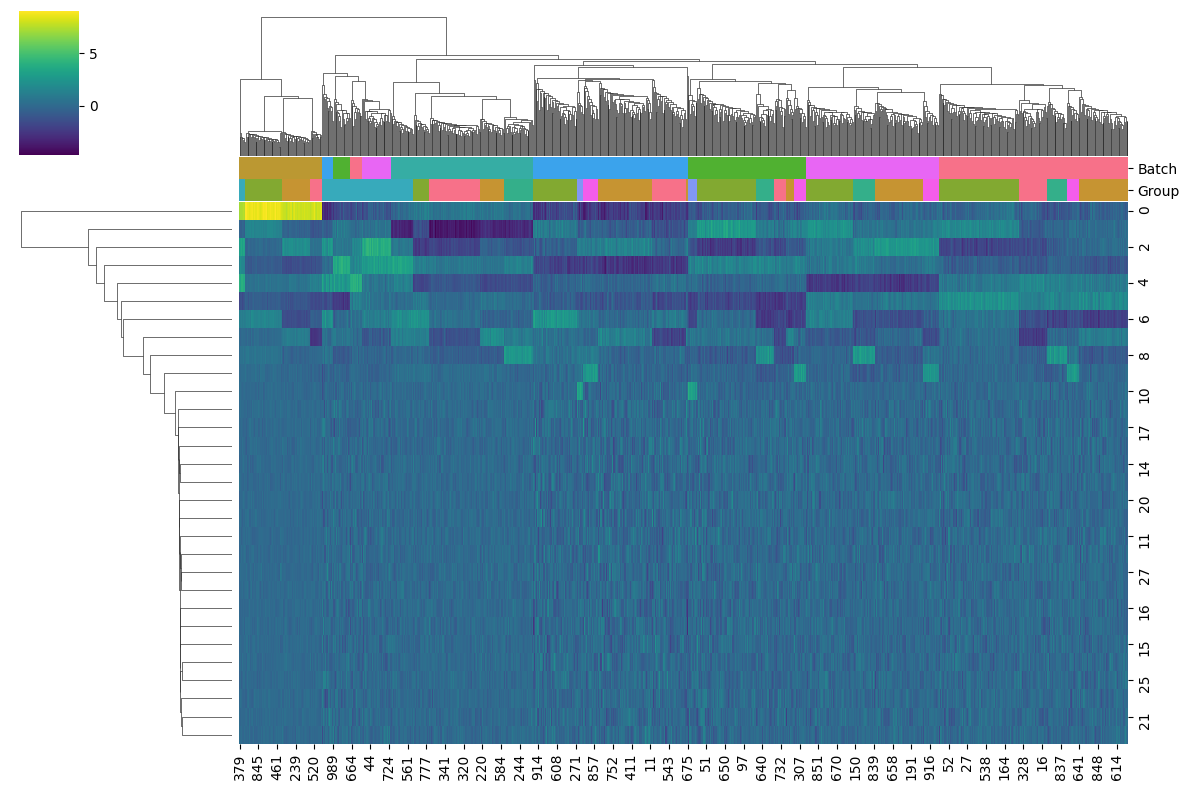

In [38]:
ccd.pl.clustermap_with_annotations(adata_ds, key='X_pca', obs_keys=['Batch', 'Group']) 

111
Converting sparse matrix to dense matrix


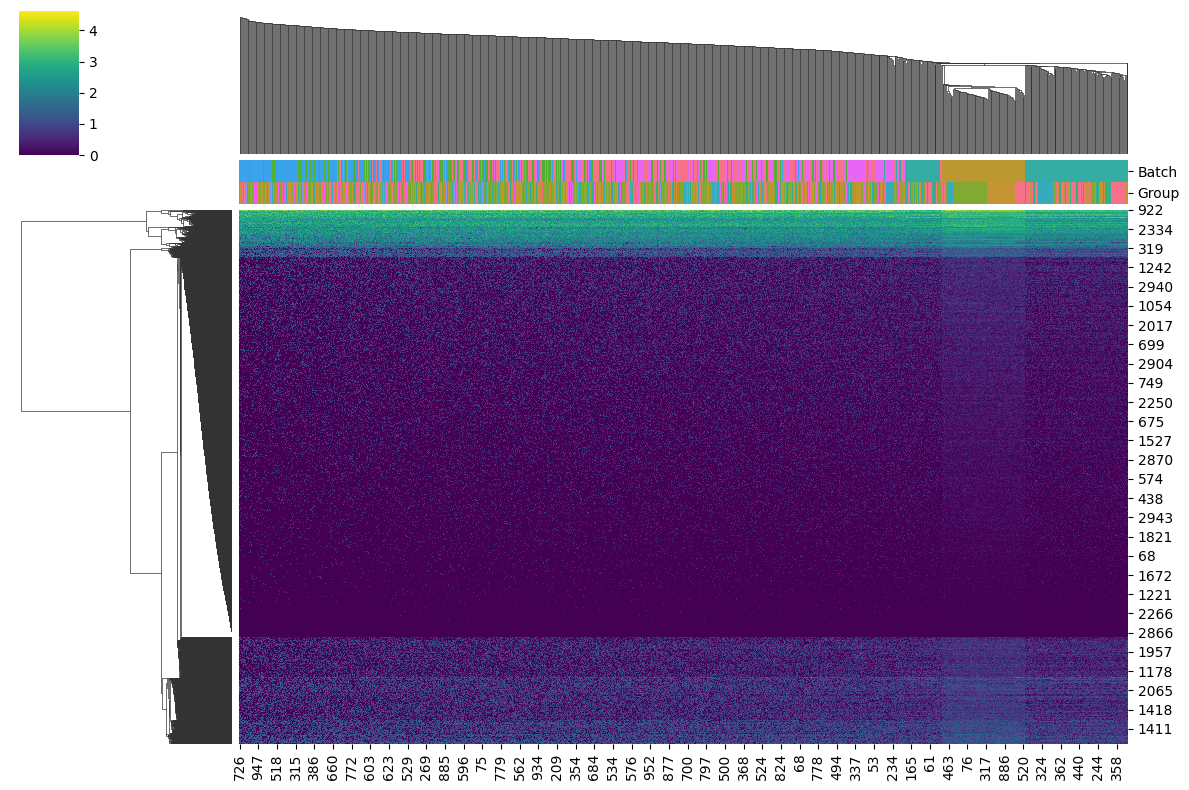

In [52]:
ccd.pl.clustermap_with_annotations(adata_ds, key='X', obs_keys=['Batch', 'Group']) 

## No correction

In [9]:
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, min_dist=0.1)

In [10]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

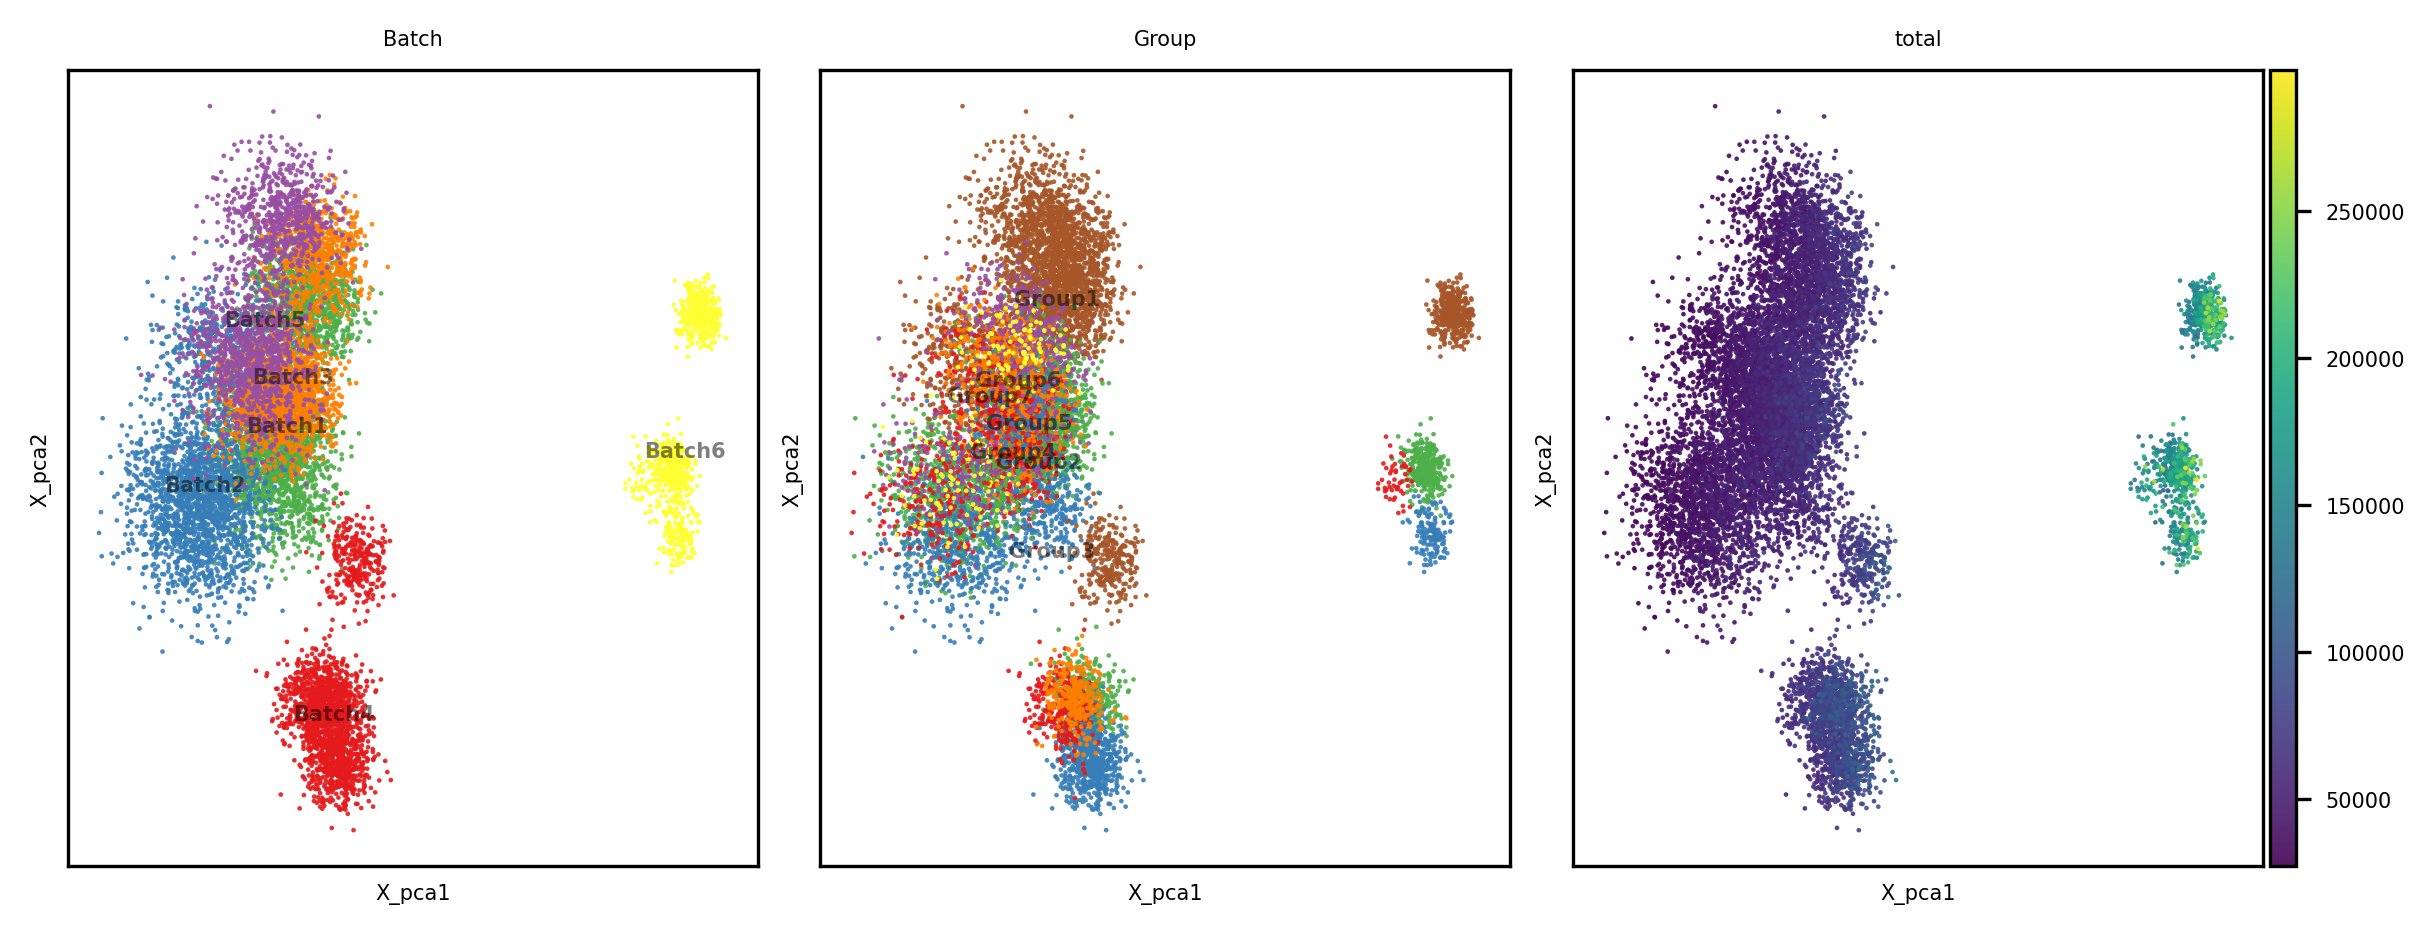

In [24]:
show_basis = 'X_pca'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

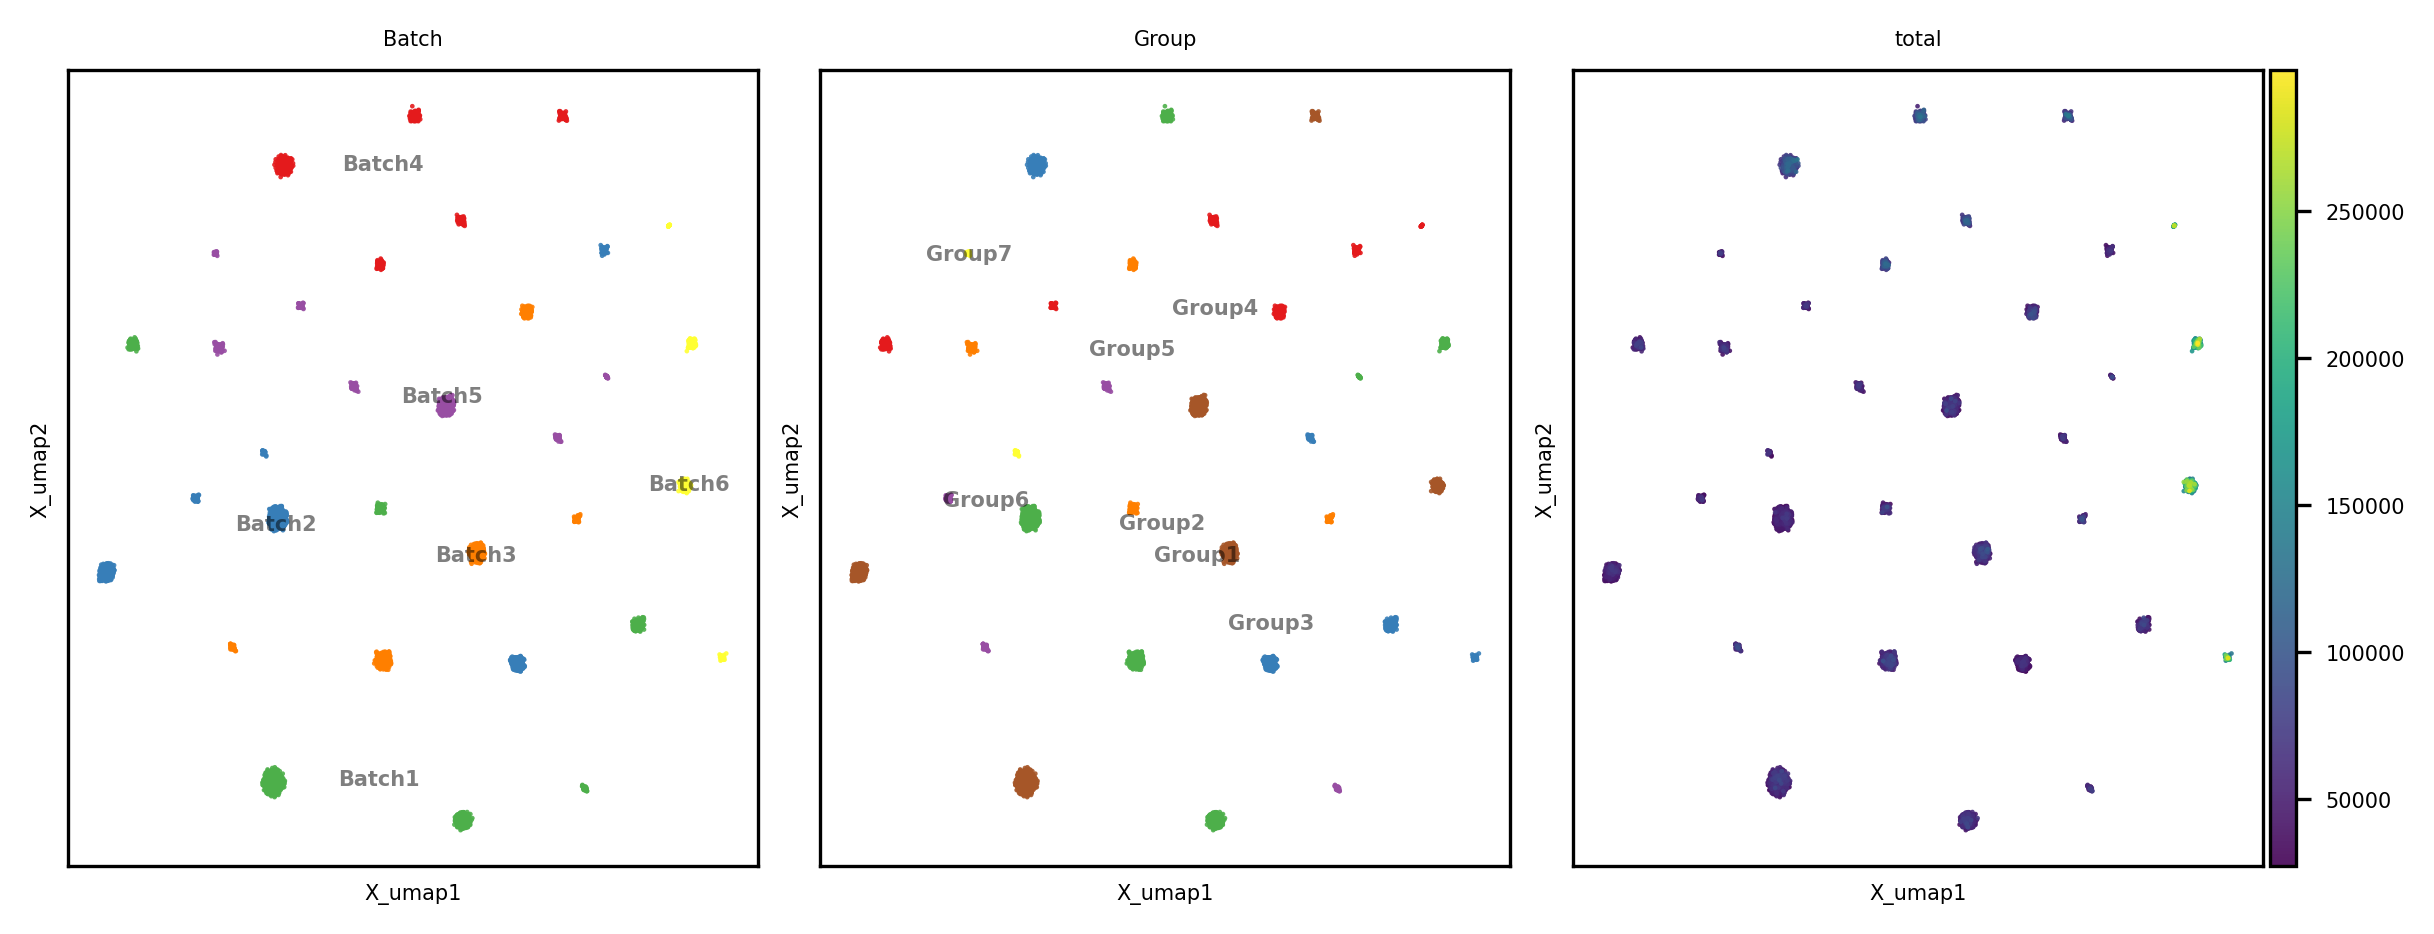

In [12]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)

In [31]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      n_epochs=5,
                      domain_key='Batch', # key indicating batch
                      augmentation_mask_prob = 0.5, # augmentation mask probability, recommend between 0.1 and 0.7
                      clr_temperature = 0.5, # temperature for NT-Xent loss
                      seed=seed, # random seed
                      p_intra_domain = 1.0, # probability of intra-domain sampling
                      verbose=False, # print training progress
                      inplace=True, # whether to modify original adata, set to False if you want to keep all expressions
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
file_suffix = f"{proj_name}_{time.strftime('%b%d-%H%M')}"
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.


Epoch 0 Training: 186it [00:02, 63.87it/s, loss=4.99]
Epoch 4 Training: 100%|██████████| 186/186 [00:02<00:00, 64.58it/s, loss=4.47]


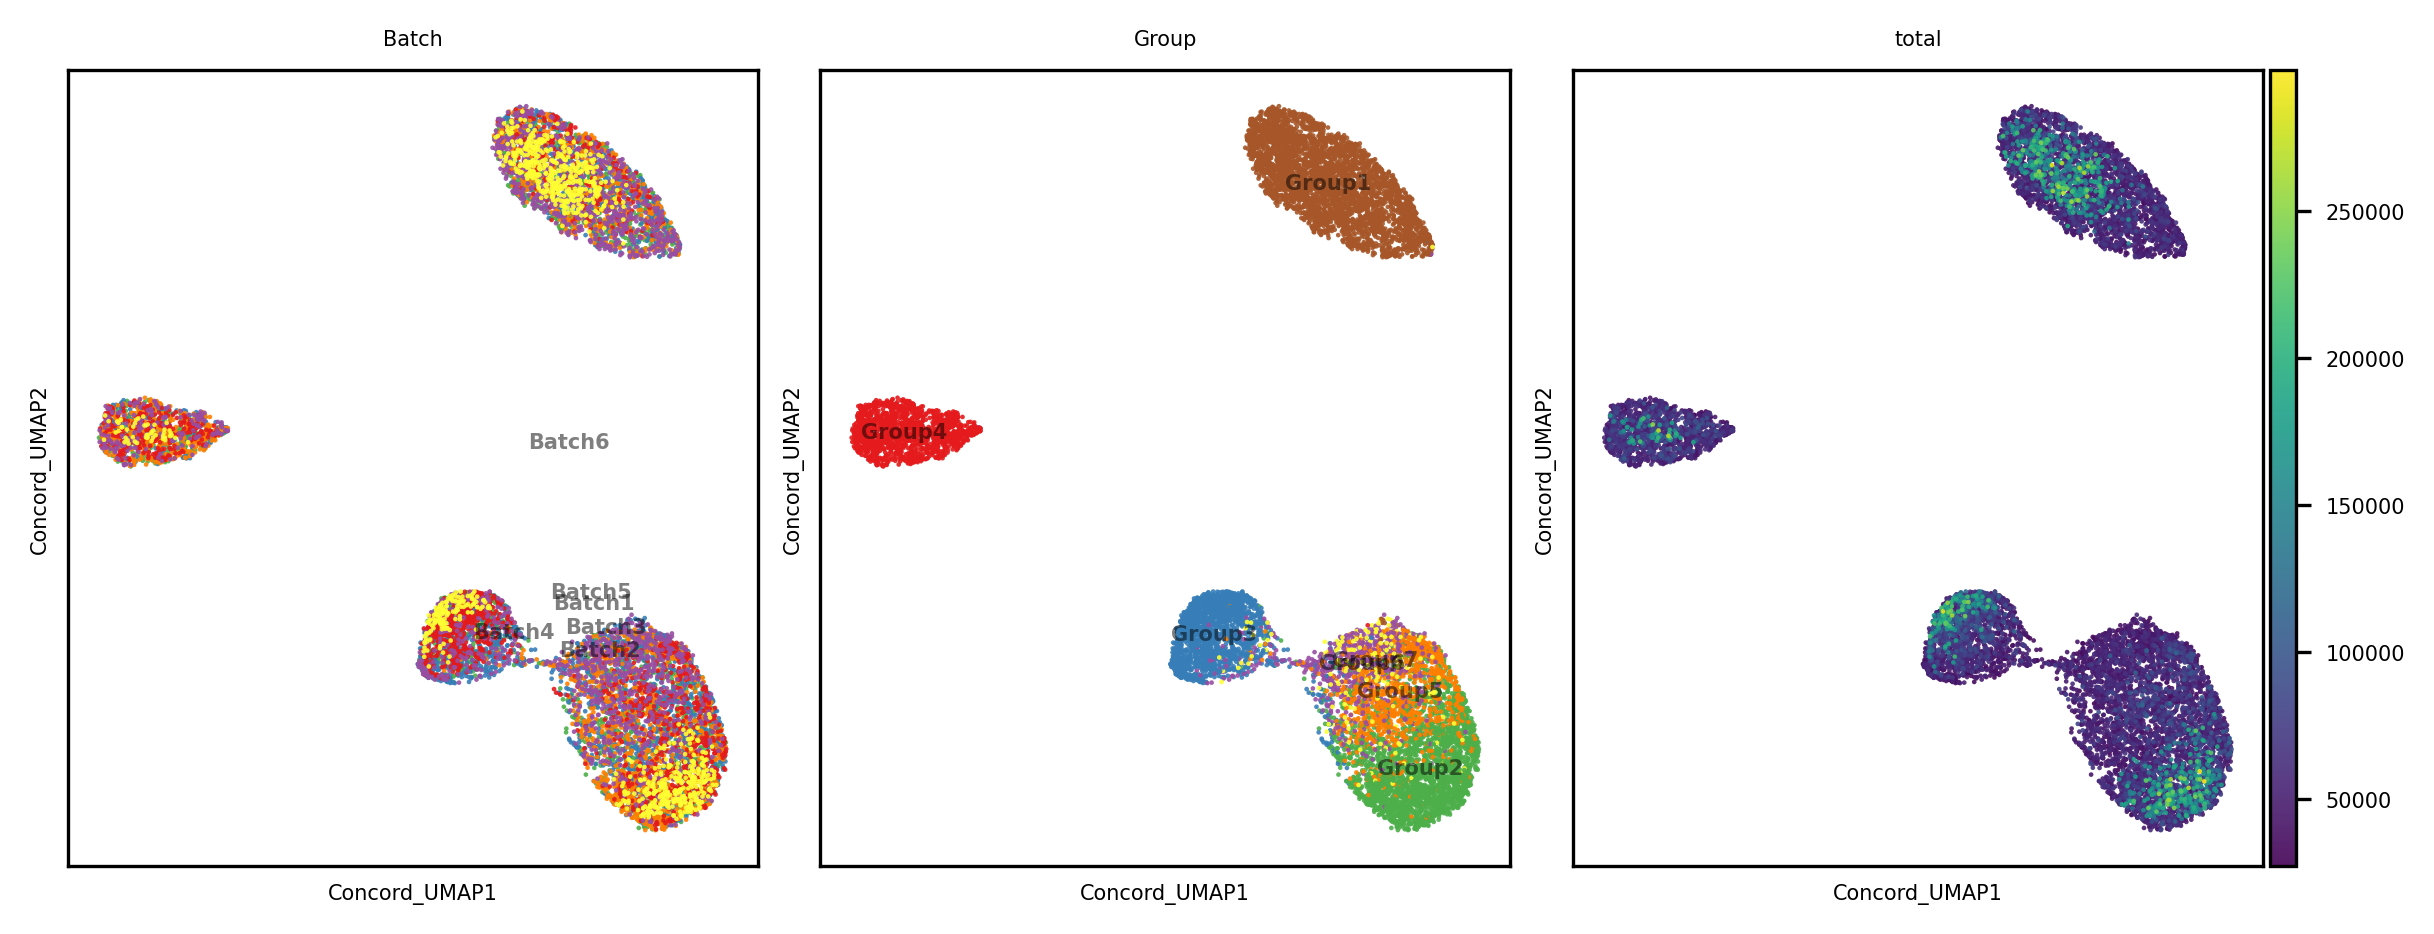

In [32]:
ccd.ul.run_umap(adata, source_key=output_key, umap_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
output_key = 'Concord'
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embeddings_{show_basis}_{file_suffix}.png"
)